# Initialization

## Import

In [8]:
import matplotlib.pyplot as plt
import model_tune_helpers.lgbm_optuna.feature_importance_extractor as feat_imp_ext
import jupiter_experiments.tuner as tuner
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import model_tune_helpers.ts_splitter as ts_splitter
import warnings
warnings.filterwarnings('ignore')

## Constants

In [2]:
METRIC = 'rmse'
OBJECTIVE = 'regression'
OPTIMIZATION_DIRECTION = 'minimize'
CATEGORIES = [[], ['season'], ['month'], ['year'], ['season', 'month'], ['season', 'month', 'year'], ['season', 'month', 'weekday']]

TRAIN_DATE_FROM = '2015-01-08'
TRAIN_DATE_TO = '2023-02-05'
VAL_DATE_FROM = '2023-02-06'
VAL_DATE_TO = '2023-02-12'

CSV_JOINT_FILE = '../../datasources/ds_joint/ds.csv'
CSV_SCORE_FILE = '../../datasources/pm25_scores/score.csv'

## Source data load

In [3]:
df_joint = pd.read_csv(CSV_JOINT_FILE, parse_dates=True, index_col='DatetimeEnd')

In [4]:
df_score = pd.DataFrame(columns=['train_score', 'val_score', 'target', 'pol_id', 'weather_YN', 'AQI_lags_YN', 'C_lags_YN', 'simple_lags_YN', 'gen_lags_YN', 'params', 'categories', 'top_feat_count'])

## Functions

In [5]:
def score_by_feature_count(o_helper, len_features, params, categories):
    tr_by_cat = []
    vl_by_cat = []
    o_helper.study_best_params = params
    for cat in categories:
        train_scs = []
        val_scs = []
        for i in range(1, len_features):
            o_helper.set_best_features_by_count(i)
            score_tr, score_vl, mdl = o_helper.run_model_and_eval(params=params,  categorical_features=cat, best_features_only=True, set_as_best_model=False)
            train_scs.append(score_tr)
            val_scs.append(score_vl)
        tr_by_cat.append(train_scs)
        vl_by_cat.append(val_scs)
    return tr_by_cat, vl_by_cat


def plot_score_grouped_by_categories_by_feature_count(len_features, score_by_cat, sub_title=""):
    plt.figure(figsize=(21, 7))
    for i in range(0, len(categories)):
        plt.plot(range(1, len_features),score_by_cat[i], label=("_".join(categories[i]) if len(categories[i]) > 0 else "no_cat"))
    plt.title(f'Score by features count. {sub_title}')
    plt.legend()
    plt.show()


def plot_train_val_score_by_feature_count(len_features, train_scs, val_scs, sub_title=""):
    plt.figure(figsize=(21, 7))
    plt.plot(range(1, len_features),train_scs, label="train_score")
    plt.plot(range(1, len_features),val_scs, label="val_score")
    plt.title(f'Train/Val score by features count. {sub_title}')
    plt.legend()
    plt.show()


def score_and_plot_by_feature_count(o_helper, len_features, params, categories):
    tr_by_cat, vl_by_cat = score_by_feature_count(o_helper, len_features, params, categories)
    plot_score_grouped_by_categories_by_feature_count(len_features, tr_by_cat, sub_title="Train scores")
    plot_score_grouped_by_categories_by_feature_count(len_features, vl_by_cat, sub_title="Val scores")
    for i in range(len(categories)):
        plot_train_val_score_by_feature_count(len_features, tr_by_cat[i], vl_by_cat[i],
                                              sub_title=f"First cats: {('_'.join(categories[i]) if len(categories[i]) > 0 else 'no_cat')}")


def init_optuna_helper(df, pol_id, default_category, categories, use_aqi_cols=False, use_c_mean_cols=True, use_lag_cols=True, use_gen_lags_cols=True, use_weather_cols=True):
    default_params = {'n_jobs': -1, 'verbosity': -1, 'metric': METRIC, 'boosting_type': 'gbdt',
    'extra_trees': True, 'n_estimators': 1000, 'num_leaves': 150, 'learning_rate': 0.01, 'subsample': 0.7, 'subsample_freq': 5, 'subsample_for_bin': 100000, 'min_child_samples': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.2, 'max_depth': 10, 'max_bin': 150}
    o_helper, x_tr, y_tr, x_vl, y_vl = tuner.init_optuna(
        df_timeseries=df, pol_id=pol_id, prediction_value_type="AQI",
        use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
        train_start_dt=TRAIN_DATE_FROM, train_end_dt=TRAIN_DATE_TO, test_start_dt=VAL_DATE_FROM, test_end_dt=VAL_DATE_TO, default_params=default_params, default_category=default_category, categories_for_optimization=categories, default_top_features_count=-1)
    return o_helper, x_tr, y_tr, x_vl, y_vl


def run_test(df, pol_id, default_category, categories, use_aqi_cols=False, use_c_mean_cols=True, use_lag_cols=True, use_gen_lags_cols=True, use_weather_cols=True):

    o_helper, x_tr, y_tr, x_vl, y_vl = init_optuna_helper(df, pol_id, default_category, categories, use_aqi_cols, use_c_mean_cols, use_lag_cols,use_gen_lags_cols, use_weather_cols)

    o_helper.run_params_search(n_trials=100, n_jobs=6, study_name="_", save_best_params=True,   direction=OPTIMIZATION_DIRECTION, best_features_only=True, search_category=True, with_pruner=True, cv_splitter= TimeSeriesSplit(16), warm_params=None)

    best_params = o_helper.study_best_params
    best_categories =  o_helper.study_best_params['categorical_features']
    best_features_count = len(x_tr.columns)

    score_train, score_val, _ = o_helper.run_model_and_eval(params=best_params,  categorical_features=best_categories, best_features_only=True, set_as_best_model=True)

    feat_imp_df = feat_imp_ext.get_and_plot_feature_importance(o_helper.best_model, o_helper.best_features_list, num=30, plot_bar=True)
    return o_helper, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df


def run_model_by_feature_count(o_helper, best_params, best_categories, best_features_count):
    o_helper.study_best_params = best_params
    o_helper.set_best_features_by_count(best_features_count)
    score_tr, score_vl, _ = o_helper.run_model_and_eval(params=best_params,  categorical_features=best_categories, best_features_only=True, set_as_best_model=True)
    return score_tr, score_vl


def save_score_and_params(target, pol_id, use_weather_cols, use_aqi_cols, use_c_mean_cols, use_lag_cols, use_gen_lags_cols,
                          best_params, best_categories, best_features_count, score_train, score_val):
    df_score.loc[df_score.shape[0]] = {'target': target, 'pol_id' : pol_id, 'weather_YN': use_weather_cols, 'AQI_lags_YN': use_aqi_cols,
                                       'C_lags_YN': use_c_mean_cols, 'simple_lags_YN': use_lag_cols, 'gen_lags_YN': use_gen_lags_cols,
                                       'params': best_params, 'categories': best_categories, 'top_feat_count': best_features_count,
                                       'train_score': score_train, 'val_score': score_val }
    df_score.to_csv(CSV_SCORE_FILE)

# Test models

## PM 2.5

### PM2.5 - AQI weather, lags, gen lags

In [6]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols =True
use_weather_cols = True

In [7]:
# lgb_train = lgb.Dataset(data=x_train, label=y_train,
#                         categorical_feature=categorical_features)
# lgb_eval = lgb.Dataset(data=x_val, label=y_val,
#                        categorical_feature=categorical_features,
#                        reference=lgb_train)
# evals_result = {}
# callbacks = [early_stopping(100, verbose=False), log_evaluation(0)]
#
# if pruning_callback is not None:
#     callbacks.append(pruning_callback)
#
# model = lgb.train(params, lgb_train,
#                   num_boost_round=50,
#                   categorical_feature=categorical_features,
#                   # valid_sets=[lgb_train, lgb_eval],
#                   # valid_names=["train", "val"],
#                   verbose_eval=False,
#                   # evals_result=evals_result,
#                   # callbacks=callbacks
#                   )
#
# train_score = evals_result['train'][self.metric][-1]
# val_score = evals_result['val'][self.metric][-1]
# if set_as_best_model:
#     self.__save_best_model(model, categorical_features, train_score, val_score)
# return train_score, val_score, model

In [9]:
default_params = {'n_jobs': -1, 'verbosity': -1, 'metric': 'rmse', 'boosting_type': 'gbdt',
'extra_trees': True, 'n_estimators': 1000, 'num_leaves': 150, 'learning_rate': 0.01, 'subsample': 0.7, 'subsample_freq': 5, 'subsample_for_bin': 100000, 'min_child_samples': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.2, 'max_depth': 10, 'max_bin': 150}

o_helper, x_tr, y_tr, x_vl, y_vl = tuner.init_optuna(
    df_timeseries=df_joint, pol_id=pol_id, prediction_value_type="AQI",
    use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
    train_start_dt=TRAIN_DATE_FROM, train_end_dt=TRAIN_DATE_TO, test_start_dt=VAL_DATE_FROM, test_end_dt=VAL_DATE_TO, default_params=default_params, default_category=default_category, categories_for_optimization=categories, default_top_features_count=-1)

In [ ]:
{'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 3000, 'num_leaves': 57, 'learning_rate': 0.05506549255255998, 'subsample': 0.1743215556252623, 'subsample_freq': 5, 'subsample_for_bin': 295339, 'min_child_samples': 284, 'reg_alpha': 0.6873083223630964, 'reg_lambda': 0.5414791465350673, 'max_depth': 11, 'max_bin': 229, 'categorical_features': ['season', 'month', 'weekday']}

run_params_search n_trials=100, search_category=True, best_features_only=True, with_pruner=True


  0%|          | 0/100 [00:00<?, ?it/s]

Trial 0 finished with best value: 47.65738808816404 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 2600, 'num_leaves': 43, 'learning_rate': 0.057825301370103506, 'subsample': 0.1233713240097077, 'subsample_freq': 6, 'subsample_for_bin': 423104, 'min_child_samples': 204, 'reg_alpha': 0.6771331949462018, 'reg_lambda': 0.1514133559938574, 'max_depth': 4, 'max_bin': 223, 'categorical_features': ['season', 'month', 'weekday']}. 
Trial 4 finished with best value: 34.6169052534787 and parameters: {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 1700, 'num_leaves': 49, 'learning_rate': 0.11650310063766489, 'subsample': 0.3955142463108443, 'subsample_freq': 10, 'subsample_for_bin': 482423, 'min_child_samples': 364, 'reg_alpha': 0.7674189659582914, 'reg_lambda': 0.1697367666813675, 'max_depth': 9, 'm

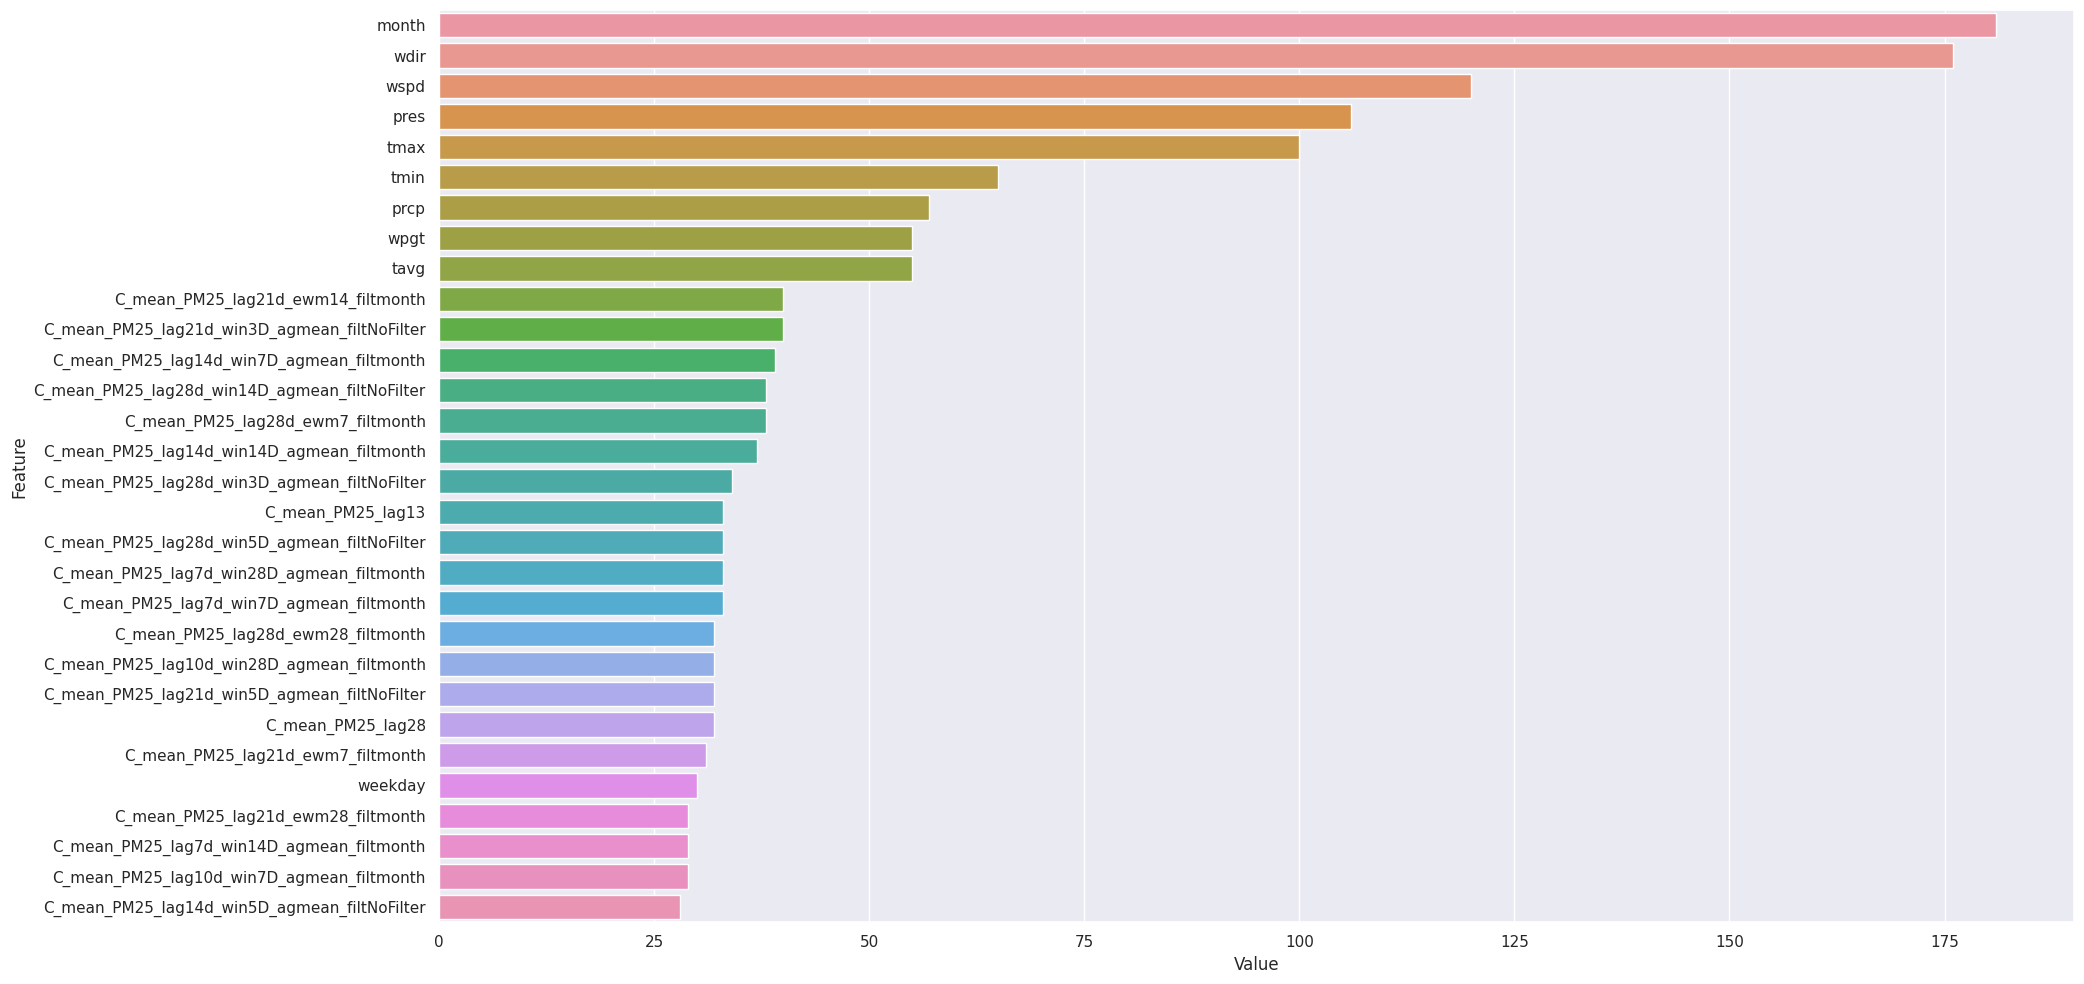

(8.330141813585344, 39.172289961058844)

In [9]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [17]:
dddf = optuna_tuner.study.trials_dataframe()
#dddf[[dddf['state'] == 'FAIL']]
dddf[dddf['state'] == 'FAIL']

,number,value,datetime_start,datetime_complete,duration,params_boosting_type,params_categorical_features,params_extra_trees,params_learning_rate,params_max_bin,...,params_n_jobs,params_num_leaves,params_objective,params_reg_alpha,params_reg_lambda,params_subsample,params_subsample_for_bin,params_subsample_freq,params_verbosity,state


In [ ]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}

score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), params=best_params, categories=categories)

In [ ]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}
best_categories = ['month', 'weekday']
best_features_count = 70

optuna_tuner, _, _, _, _ = init_optuna_helper(df_joint, pol_id, default_category=best_categories, categories=[],
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
                                          use_weather_cols=use_weather_cols)

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI lags, gen lags

In [ ]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols =True
use_weather_cols = False

In [ ]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 2900, 'num_leaves': 66, 'learning_rate': 0.12773019092749138, 'subsample': 0.7831659496800467, 'subsample_freq': 8, 'subsample_for_bin': 391616, 'min_child_samples': 73, 'reg_alpha': 0.6968311953663399, 'reg_lambda': 0.32426383763516786, 'max_depth': 5, 'max_bin': 329}
best_categories = ['month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI weather, lags

In [ ]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols =False
use_weather_cols = True

In [ ]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
#score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [ ]:
best_categories = ['month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI weather, gen lags

In [ ]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = False
use_gen_lags_cols =True
use_weather_cols = True

In [ ]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
# best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 1600, 'num_leaves': 145, 'learning_rate': 0.09686633344736045, 'subsample': 0.9783886230574863, 'subsample_freq': 3, 'subsample_for_bin': 210165, 'min_child_samples': 36, 'reg_alpha': 0.6996611491876404, 'reg_lambda': 0.6668213755991776, 'max_depth': 5, 'max_bin': 339}

score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), params=best_params, categories=categories)

In [ ]:
best_categories = ['season', 'month']
best_features_count = 73

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
best_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}
best_categories = ['month', 'weekday']
best_features_count = 73

optuna_tuner, _, _, _, _ = init_optuna_helper(df_joint, pol_id, default_category=best_categories, categories=[],
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols,
                                          use_weather_cols=use_weather_cols)

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), params=best_params, categories=categories)

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI gen lags

In [ ]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = False
use_gen_lags_cols =True
use_weather_cols = False

In [ ]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
#score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [ ]:
best_categories = ['month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

### PM2.5 - AQI lags

In [ ]:
pol_id = 6001
categories=[['month', 'weekday'], ['season', 'month'], ['season', 'month', 'weekday']]
default_category=['month', 'weekday']
use_aqi_cols = False
use_c_mean_cols=True
use_lag_cols = True
use_gen_lags_cols = False
use_weather_cols = False

In [ ]:
optuna_tuner, score_train, score_val, best_params, best_categories, best_features_count, feat_imp_df = \
    run_test(df_joint, pol_id, default_category=default_category, categories=categories,
             use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols)
score_train, score_val

In [ ]:
#score_and_plot_by_feature_count(optuna_tuner, len_features=min(best_features_count, 150), best_params=best_params, categories=categories)

In [ ]:
best_categories = ['season', 'month', 'weekday']
best_features_count = 70

score_train, score_val = run_model_by_feature_count(optuna_tuner, best_params, best_categories=best_categories, best_features_count=best_features_count)
score_train, score_val

In [ ]:
save_score_and_params(target='AQI', pol_id=pol_id, use_weather_cols=use_weather_cols, use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
                      use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, best_params=best_params, best_categories=best_categories,
                      best_features_count=best_features_count, score_train=score_train, score_val=score_val)

# Forecasts comparison

In [ ]:
df_score = pd.read_csv(CSV_SCORE_FILE)
df_score.sort_values(by='val_score', inplace=True)
display(df_score)

In [ ]:
_, y_val = ts_splitter.split_x_y_for_period(df_timeseries=df_joint, index_cols='DatetimeEnd', y_value_col='AQI',                                                           dt_start=VAL_DATE_FROM, dt_end=VAL_DATE_TO)

In [ ]:
def get_prediction(df, pol_id, use_weather_cols, use_aqi_cols, use_c_mean_cols, use_lag_cols, use_gen_lags_cols, best_params, best_categories, best_feat_count):
    o_helper, _, _, x_vl, _ = tuner.init_optuna(
        df_timeseries=df, pol_id=pol_id, prediction_value_type="AQI",
        use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols,
        use_lag_cols=use_lag_cols, use_gen_lags_cols=use_gen_lags_cols, use_weather_cols=use_weather_cols,
        train_start_dt=TRAIN_DATE_FROM, train_end_dt=TRAIN_DATE_TO, test_start_dt=VAL_DATE_FROM, test_end_dt=VAL_DATE_TO,
        default_params=best_params, default_category=best_categories, default_top_features_count=best_feat_count)

    score_train, score_val, _ = o_helper.run_model_and_eval(best_features_only=True, set_as_best_model=True)
    y_vl_pred = [int(round(x, 0)) for x in o_helper.predict_by_best_model(x_vl)]
    return score_train, score_val, y_vl_pred

In [ ]:
plt.figure(figsize=(15, 4))
plt.title(f"Прогноз AQI на последние 7 дней")
plt.plot(y_val, label="actual")

for index, row in df_score.iterrows():
    str_type = ''
    if row['weather_YN']:
            str_type = 'Weather'
    if row['simple_lags_YN']:
        if str_type != '':
            str_type = str_type + '_'
        str_type = str_type + 'SimpleLags'
    if row['gen_lags_YN']:
        if str_type != '':
            str_type = str_type + '_'
        str_type = str_type + 'GenLags'

    best_pm25_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}
    best_pm25_categories = ['month', 'weekday']
    best_pm25_features_count = 70

    score_train, score_val, y_pred = get_prediction(df_joint, row['pol_id'], row['weather_YN'], row['AQI_lags_YN'], row['C_lags_YN'], row['simple_lags_YN'], row['gen_lags_YN'], eval(row['params']), eval(row['categories']), row['top_feat_count'])
    print(f'{str_type}: train score: {score_train}, val score: {score_val}')
    plt.plot(y_val.index, y_pred, label=str_type + ". RMSE=%.2f" % score_val)


plt.legend()
plt.grid(True)
plt.show()